74


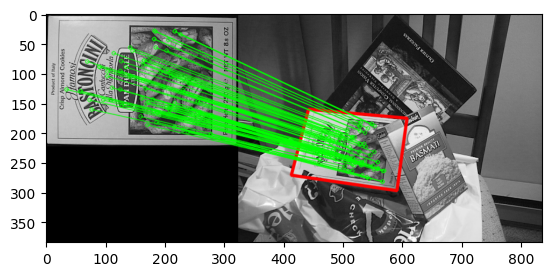

(<matplotlib.image.AxesImage at 0x14dd7a5ebd0>, None)

In [1]:
#findHomography
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img1 = cv.imread('../data/box.png')          # 索引图像
img2 = cv.imread('../data/box_in_scene.png') # 训练图像
sift = cv.SIFT_create()
# 用SIFT找到关键点和描述符
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
#FLANN匹配器参数
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
#创建FLANN匹配器
flann = cv.FlannBasedMatcher(index_params, search_params)
#得到所有匹配结果
matches = flann.knnMatch(des1,des2,k=2)

# ＃根据Lowe的比率测试存储所有符合条件的匹配项。
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

MIN_MATCH_COUNT = 4
# 如果找到足够的匹配项，则通过透视变换找到对象。
print(len(good))
if len(good)>MIN_MATCH_COUNT:
    # 获取关键点的坐标
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    # 通过RANSAC算法计算透视变换矩阵，其中good是匹配点，mask是掩码，M是变换矩阵
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    # matchesMask是一个掩码，它指示哪些点是匹配的。
    matchesMask = mask.ravel().tolist()
    # 获取图像的高度和宽度
    h,w,d = img1.shape
    # 使用图像的高度和宽度对原始图像的四个角进行透视变换，以便在训练图像中找到对象。
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    # 通过透视变换找到对象。
    dst = cv.perspectiveTransform(pts,M)
    # 在训练图像中绘制边框
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

# dict是字典类型，**dict是将字典扩展为关键字参数,关键字参数是指在函数调用时，
# 函数参数的顺序与定义时不一致，但是因为有了关键字，函数能正确的调用。
draw_params = dict(matchColor = (0,255,0), # 用绿色绘制匹配
                singlePointColor = None,
                matchesMask = matchesMask, # 只绘制内部点
                flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()